In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FP-KK/dataset/train_baseline.csv'
dataset = pd.read_csv(dataset_path, encoding= 'unicode_escape')
dataset.shape

(839815, 6)

In [4]:
dataset.drop(['Unnamed: 0'], inplace=True, axis=1)
dataset

,Sentence #,Word,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,O,28285,14
1,Sentence: 1,of,O,15741,14
2,Sentence: 1,demonstrators,O,1523,14
3,Sentence: 1,have,O,367,14
4,Sentence: 1,marched,O,13632,14
...,...,...,...,...,...
839810,Sentence: 44529,as,O,21619,14
839811,Sentence: 44529,alternatives,O,21279,14
839812,Sentence: 44529,to,O,34610,14
839813,Sentence: 44529,oil,O,23416,14


In [5]:
dataset["Tag"].value_counts()

O        711029
B-geo     30162
B-tim     16251
B-org     16125
I-per     13917
B-per     13667
I-org     13583
B-gpe     12492
I-geo      5959
I-tim      5269
B-art       319
I-art       252
B-eve       240
I-eve       200
B-nat       162
I-gpe       154
I-nat        34
Name: Tag, dtype: int64

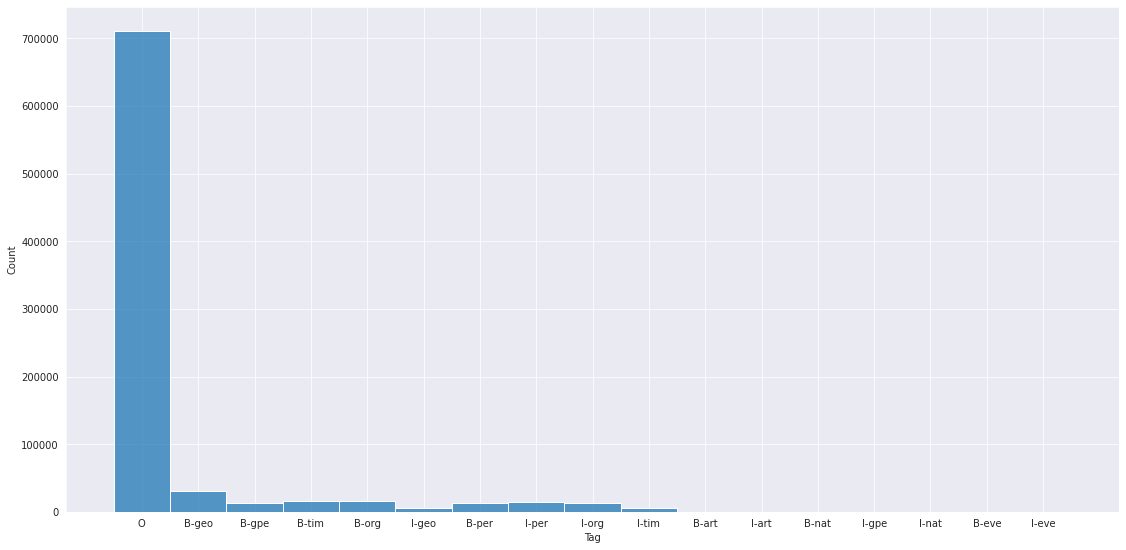

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16,8))
sns.set_style('darkgrid')
sns.histplot(dataset['Tag'])
plt.tight_layout(pad=2)
plt.show()

In [7]:
dataset_fillna = dataset.fillna(method='ffill', axis=0)
dataset_group = dataset_fillna.groupby(['Sentence #'], as_index=False)['Word', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [8]:
dataset_group

,Sentence #,Word,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[28285, 15741, 1523, 367, 13632, 7168, 25967, ...","[14, 14, 14, 14, 14, 14, 6, 14, 14, 14, 14, 14..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[34424, 1990, 32928, 9794, 31792, 34610, 15641...","[7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[28347, 29190, 19208, 2838, 24041, 26531, 7258...","[14, 14, 16, 14, 14, 14, 14, 14, 6, 14, 14, 14..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]","[4139, 30932, 1336, 28550, 18536, 21258, 26975...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[30896, 25325, 14734, 12754, 18505, 433, 7325,...","[6, 14, 14, 4, 5, 14, 16, 14, 6, 14, 7, 14, 7,..."
...,...,...,...,...,...
38363,Sentence: 44525,"[President, Bush, called, on, the, United, Sta...","[B-per, I-per, O, O, O, B-geo, I-geo, O, O, O,...","[344, 19638, 28590, 29279, 3894, 18510, 6565, ...","[4, 5, 14, 14, 14, 6, 0, 14, 14, 14, 14, 14, 1..."
38364,Sentence: 44526,"[Mr., Bush, said, dependence, on, foreign, sou...","[B-per, I-per, O, O, O, O, O, O, O, O, B-geo, ...","[188, 19638, 433, 7527, 29279, 11236, 5495, 15...","[4, 5, 14, 14, 14, 14, 14, 14, 14, 14, 6, 14, ..."
38365,Sentence: 44527,"[The, president, called, for, reducing, gasoli...","[O, O, O, O, O, O, O, O, O, B-geo, O, O, O, B-...","[20005, 3610, 28590, 12209, 28521, 30306, 3119...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 6, 14, 14..."
38366,Sentence: 44528,"[He, said, the, goal, can, be, met, by, increa...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[22908, 433, 3894, 32462, 14067, 26107, 19184,...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1..."


Selanjutnya akan dilakukan stopwords removal. Pada konteks NER, hal ini termasuk proses undersampling, yaitu mengeliminasi stopwords yang diasumsikan merupakan kelas negatif yang dominan, yaitu token dengan tag O

In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = list(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
print(stop_words)

['was', "mustn't", 'to', 'that', 'no', 'yours', 'more', "haven't", "isn't", 'having', 'had', "couldn't", 'mightn', 'off', 'down', 'now', 'them', 'same', 'those', 'further', 'doing', 'has', 've', 'where', 'shouldn', "shan't", 'should', 'against', 'which', 'because', 'her', 'during', 'there', 'she', 'other', 'only', 'his', 'they', 'our', "don't", 'needn', 'the', 'were', 'just', "aren't", 'he', "she's", "hadn't", 'such', 'hasn', "wasn't", 'isn', 'll', 'does', 'it', 'did', "won't", "you're", 'from', 'both', 're', 't', 'then', "needn't", 'wasn', 'you', "you've", 'an', 'this', 'and', 'ma', "it's", 'nor', 'aren', 'me', 'him', "doesn't", 'for', 'how', 'haven', 'any', 'shan', 'ain', "you'll", 'its', "that'll", 'than', 'too', "weren't", 'once', 'itself', 'in', 'couldn', 'have', 'will', 'if', 'few', "shouldn't", 'whom', 'themselves', 'when', 'ourselves', 'over', 'between', 'through', 'some', "you'd", 'wouldn', 'don', 'what', 'very', 'didn', 'd', 'ours', 'himself', 'so', 'm', 'o', 'hadn', 'with', 

In [11]:
def removeStopWord(dataset):
  for sentence_idx in range(0, dataset.shape[0]):
    stop_word_idx = []
    for word_idx in range(0, len(dataset.loc[sentence_idx, 'Word'])):
      if (dataset.loc[sentence_idx, 'Word'][word_idx] in stop_words):
        stop_word_idx.append(word_idx)
    
    for index in sorted(stop_word_idx, reverse=True):
      dataset.loc[sentence_idx, 'Word'].pop(index)
      dataset.loc[sentence_idx, 'Tag'].pop(index)
      dataset.loc[sentence_idx, 'Word_idx'].pop(index)
      dataset.loc[sentence_idx, 'Tag_idx'].pop(index)
  return dataset

In [12]:
dataset_backup = dataset_group.copy()

In [13]:
dataset_for_stopword_removal = dataset_group.copy()

In [14]:
dataset_stopwords_removed = removeStopWord(dataset_for_stopword_removal)

In [15]:
dataset_stopwords_removed

,Sentence #,Word,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, demonstrators, marched, London, pr...","[O, O, O, B-geo, O, O, B-geo, O, O, B-gpe, O, ...","[28285, 1523, 13632, 25967, 18998, 10476, 4183...","[14, 14, 14, 6, 14, 14, 6, 14, 14, 7, 14, 14, 14]"
1,Sentence: 10,"[Iranian, officials, say, expect, get, access,...","[B-gpe, O, O, O, O, O, O, O, O, O, B-tim, O, B...","[34424, 1990, 32928, 31792, 15641, 10244, 7760...","[7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 14..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, B-geo, O, O, O, O, B-or...","[28347, 29190, 19208, 2838, 24041, 26531, 4722...","[14, 14, 16, 14, 14, 14, 6, 14, 14, 14, 14, 10..."
3,Sentence: 1000,"[They, left, tense, hour-long, standoff, riot,...","[O, O, O, O, O, O, O, O]","[4139, 30932, 18536, 21258, 26975, 16894, 2241...","[14, 14, 14, 14, 14, 14, 14, 14]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[30896, 25325, 14734, 12754, 18505, 433, 7325,...","[6, 14, 14, 4, 5, 14, 16, 14, 6, 14, 7, 7, 14,..."
...,...,...,...,...,...
38363,Sentence: 44525,"[President, Bush, called, United, States, dive...","[B-per, I-per, O, B-geo, I-geo, O, O, O, O, O,...","[344, 19638, 28590, 18510, 6565, 8393, 5495, 1...","[4, 5, 14, 6, 0, 14, 14, 14, 14, 14, 10, 14, 14]"
38364,Sentence: 44526,"[Mr., Bush, said, dependence, foreign, sources...","[B-per, I-per, O, O, O, O, O, O, B-geo, O, O, ...","[188, 19638, 433, 7527, 11236, 5495, 23416, 11...","[4, 5, 14, 14, 14, 14, 14, 14, 6, 14, 14, 14, ..."
38365,Sentence: 44527,"[The, president, called, reducing, gasoline, u...","[O, O, O, O, O, O, B-geo, O, O, O, B-tim, O]","[20005, 3610, 28590, 28521, 30306, 31192, 2250...","[14, 14, 14, 14, 14, 14, 6, 14, 14, 14, 16, 14]"
38366,Sentence: 44528,"[He, said, goal, met, increasing, supply, rene...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[22908, 433, 32462, 19184, 16073, 20284, 405, ...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1..."


In [16]:
dataset_stopwords_removed_backup = dataset_stopwords_removed.copy()

In [17]:
def buildDataFrame(groupedData):
  word_list = []
  tag_list = []
  sentence_list = []
  word_idx = []
  tag_idx = []
  for sentence in range(0, groupedData.shape[0]):
    sentence_array = [groupedData.loc[sentence, 'Sentence #']] * len(groupedData.loc[sentence, 'Word'])
    sentence_list = sentence_list + sentence_array
    word_list = word_list + groupedData.loc[sentence, 'Word']
    tag_list = tag_list + groupedData.loc[sentence, 'Tag']
    word_idx = word_idx + groupedData.loc[sentence, 'Word_idx']
    tag_idx = tag_idx + groupedData.loc[sentence, 'Tag_idx']
    # print(sentence, len(sentence_list), len(word_list), len(tag_list), len(word_idx), len(tag_idx))
    # dataFrameLoop = pd.DataFrame({'Sentence #': sentence_list, 'Word': word_list, 'Tag': tag_list, 'Word_idx': word_idx, 'Tag_idx': tag_idx})
    # dataFrame = dataFrame.append([dataFrameLoop])
    # print(sentence_list, word_list, tag_list)
  dataFrame = pd.DataFrame({'Sentence #': sentence_list, 'Word': word_list, 'Tag': tag_list, 'Word_idx': word_idx, 'Tag_idx': tag_idx})
  # return sentence_list, word_list, tag_list
  return dataFrame

In [18]:
train_df_after_sampling =  buildDataFrame(dataset_stopwords_removed)

In [19]:
train_df_after_sampling["Tag"].value_counts()

O        453993
B-geo     29976
B-org     16077
B-tim     15776
I-per     13906
B-per     13667
I-org     12631
B-gpe     12492
I-geo      5803
I-tim      4493
B-art       318
B-eve       240
I-art       239
I-eve       197
B-nat       162
I-gpe       152
I-nat        34
Name: Tag, dtype: int64

In [20]:
train_df_after_sampling.to_csv('/content/drive/MyDrive/Colab Notebooks/FP-KK/dataset/train_stopwords.csv')